In [1]:
import pandas as pd
import numpy as np
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix

scaler = load('./model/iso_scaler.joblib')
iso_model = load('./model/iso_model.joblib')

#df1 = pd.read_csv("./../../data/dev101_prepared.csv")
#df2 = pd.read_csv("./../../data/dev102_prepared.csv")
df_test = pd.read_csv("./data/devAll2_prepared.csv")

In [2]:
df_test

,timestamp,devID,soil,rain,temp,humi,geo,lat,lng
0,2025-05-02 11:42:00.384119,102.0,22.200001,0.0,34.549099,61.175941,3.323395,8.637964,99.898933
1,2025-05-02 11:42:06.635276,101.0,28.799999,0.0,34.290073,62.429081,14.532875,8.637999,99.899010
2,2025-05-02 11:42:11.034615,102.0,22.200001,0.0,34.506374,61.542152,14.766250,8.637963,99.898933
3,2025-05-02 11:42:18.056572,101.0,28.799999,0.0,34.266041,64.082787,14.673310,8.637998,99.899010
4,2025-05-02 11:42:21.675224,102.0,22.200001,0.0,34.485012,61.767223,3.242806,8.637963,99.898933
...,...,...,...,...,...,...,...,...,...
301186,2025-06-29 20:25:27.980,101.0,27.900000,0.0,29.101625,81.113754,2.490953,8.638010,99.898972
301187,2025-06-29 20:25:48.980,102.0,25.600000,0.0,29.908064,77.426796,3.856516,8.637931,99.898941
301188,2025-06-29 20:26:01.100,102.0,25.600000,0.0,29.349968,80.005569,2.614293,8.637931,99.898949
301189,2025-06-29 20:26:02.150,101.0,27.900000,0.0,29.050890,81.302589,8.617684,8.638011,99.898972


In [3]:
#df_test  = pd.concat([df1, df2], ignore_index=True)
df_test.describe()

,devID,soil,rain,temp,humi,geo,lat,lng
count,301191.000000,301191.000000,301191.000000,301191.000000,301191.000000,301191.000000,301191.000000,301191.000000
mean,101.503282,48.952394,0.205600,29.871124,75.252266,8.128838,8.637978,99.898949
std,0.499990,10.397376,1.761622,3.193456,8.565651,6.716052,0.000038,0.001335
min,101.000000,21.100000,0.000000,24.238958,43.418247,0.000000,8.637330,99.166664
25%,101.000000,44.200001,0.000000,27.368584,69.429153,3.009754,8.637945,99.898926
50%,102.000000,50.400002,0.000000,28.508812,79.240715,4.383256,8.637974,99.898949
75%,102.000000,57.799999,0.000000,32.749290,81.176704,13.366670,8.638014,99.898972
max,102.000000,66.599998,41.630600,38.984512,88.510567,32.062466,8.638361,99.900078


In [4]:
# สร้าง features
feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo']
X_test = df_test[feature_cols].values
X_test_scaled = scaler.transform(X_test)

# คำนวณ anomaly score และจัดระดับความเสี่ยง
df_test['anomaly_score'] = iso_model.decision_function(X_test_scaled)

crit_thresh = -0.11
warn_thresh = 0.00

def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

df_test['predicted_risk'] = df_test['anomaly_score'].apply(classify_risk)



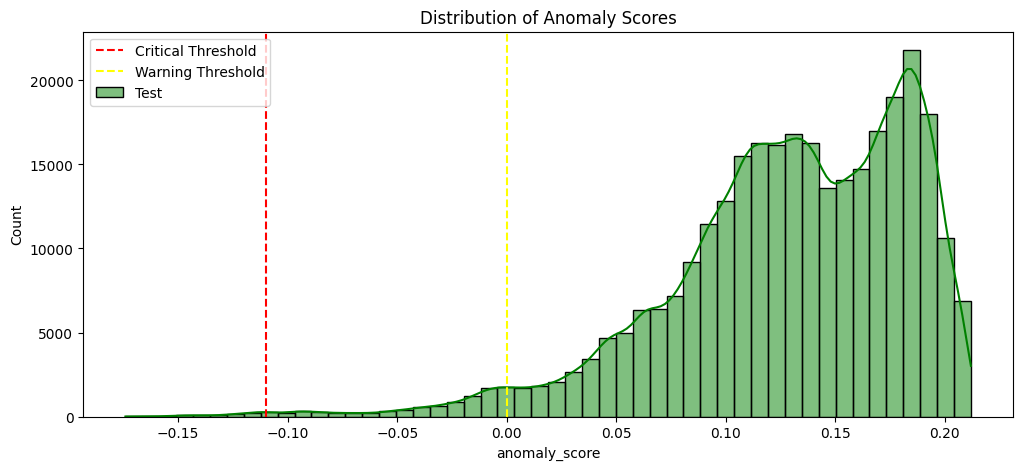

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12,5))
sns.histplot(df_test['anomaly_score'], bins=50, kde=True, color='green', label='Test')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.legend()
plt.title('Distribution of Anomaly Scores')
plt.show()



In [6]:
print(df_test['predicted_risk'].value_counts())


predicted_risk
Normal      292176
Warning       8244
Critical       771
Name: count, dtype: int64


In [7]:
print(df_test['predicted_risk'].value_counts(normalize=True) * 100) 

predicted_risk
Normal      97.006883
Warning      2.737134
Critical     0.255984
Name: proportion, dtype: float64


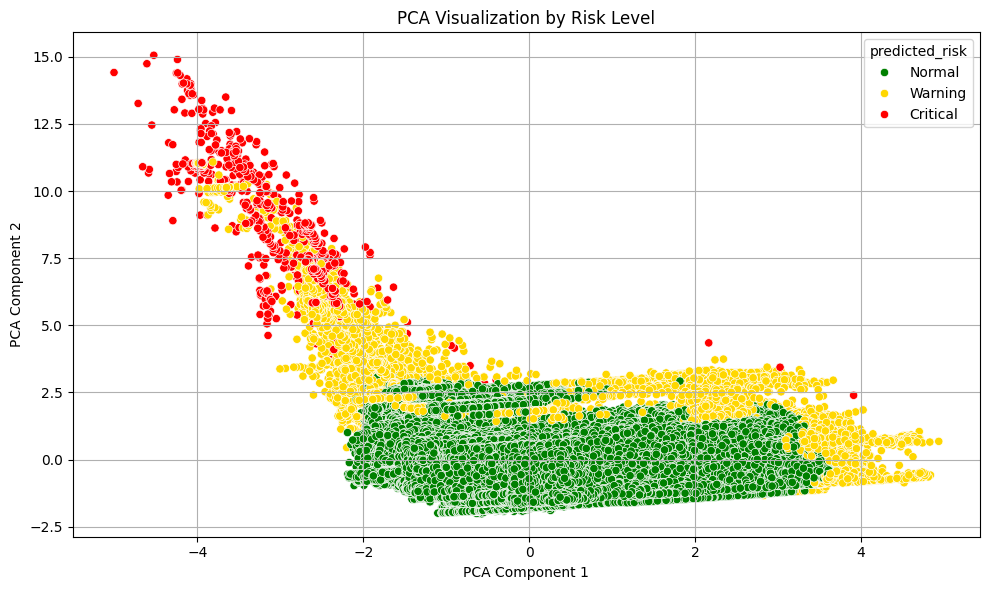

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# ทำ PCA ให้เหลือ 2 มิติ
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

df_test['pca_1'] = X_pca[:, 0]
df_test['pca_2'] = X_pca[:, 1]

risk_colors = {
    'Normal': 'green',
    'Warning': 'gold',     # เหลือง
    'Critical': 'red'
}

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_test,
    x='pca_1',
    y='pca_2',
    hue='predicted_risk',
    palette=risk_colors
)
plt.title("PCA Visualization by Risk Level")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
explained_var = pca.explained_variance_ratio_
print(f"PCA อธิบายได้ {explained_var[0]*100:.2f}% และ {explained_var[1]*100:.2f}% ของข้อมูล")


PCA อธิบายได้ 39.97% และ 22.23% ของข้อมูล


In [10]:
pca_df = pd.DataFrame(pca.components_, columns=feature_cols, index=["PC1", "PC2"])
print(pca_df.T.sort_values("PC1", ascending=False))  # เรียงตามผลต่อแกน X


           PC1       PC2
temp  0.687328  0.109401
geo  -0.008019  0.685443
rain -0.136205  0.592757
soil -0.229066  0.381586
humi -0.675643 -0.145708


C:\Users\ahmad\AppData\Local\Temp\ipykernel_17756\520709293.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_test, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')


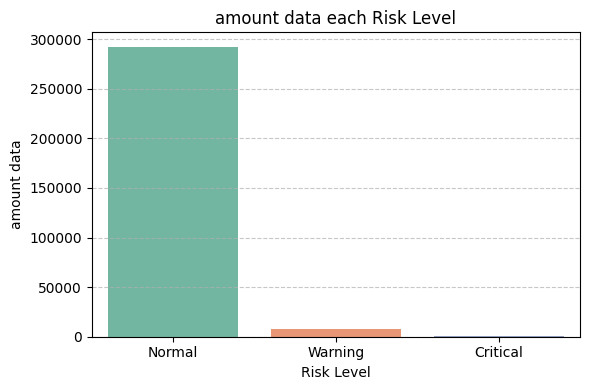

In [11]:

plt.figure(figsize=(6, 4))
sns.countplot(data=df_test, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')

plt.title('amount data each Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('amount data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:
df_test['predicted_risk'].value_counts(normalize=True) * 100

predicted_risk
Normal      97.006883
Warning      2.737134
Critical     0.255984
Name: proportion, dtype: float64

In [12]:
df_test[feature_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301191 entries, 0 to 301190
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   soil    301191 non-null  float64
 1   rain    301191 non-null  float64
 2   temp    301191 non-null  float64
 3   humi    301191 non-null  float64
 4   geo     301191 non-null  float64
dtypes: float64(5)
memory usage: 11.5 MB


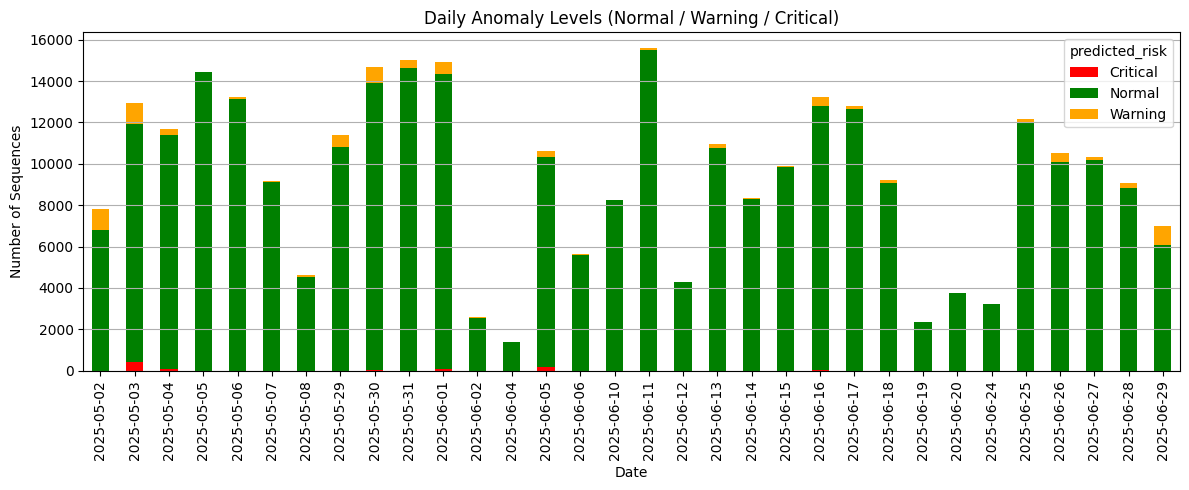

In [13]:

df_results = df_test
df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

risk_order = ['Critical', 'Normal', 'Warning']

alerts_per_day = df_results.groupby(['date', 'predicted_risk']).size().unstack(fill_value=0)

for risk in risk_order:
    if risk not in alerts_per_day.columns:
        alerts_per_day[risk] = 0

alerts_per_day = alerts_per_day[risk_order]

colors = ['red', 'green', 'orange']

alerts_per_day.plot(kind='bar', stacked=True, figsize=(12,5), color=colors)

plt.title("Daily Anomaly Levels (Normal / Warning / Critical)")
plt.xlabel("Date")
plt.ylabel("Number of Sequences")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


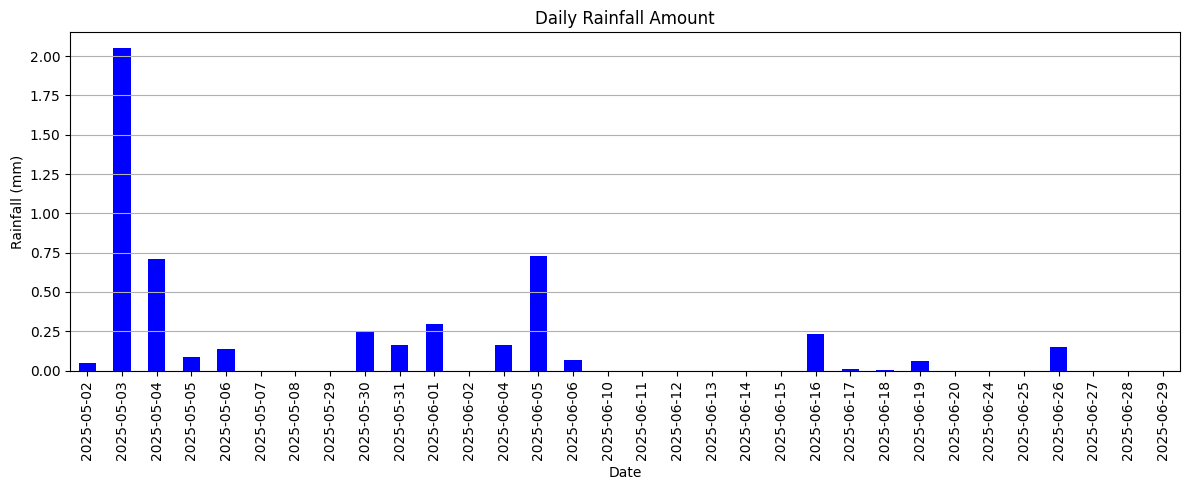

In [14]:

# สมมติ df_rain มี 'timestamp' และ 'rain_amount'

df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

# รวมปริมาณฝนรายวัน (sum)
rain_per_day = df_results.groupby('date')['rain'].mean()

# plot กราฟแท่งปริมาณฝนรายวัน
plt.figure(figsize=(12,5))
rain_per_day.plot(kind='bar', color='blue')

plt.title("Daily Rainfall Amount")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


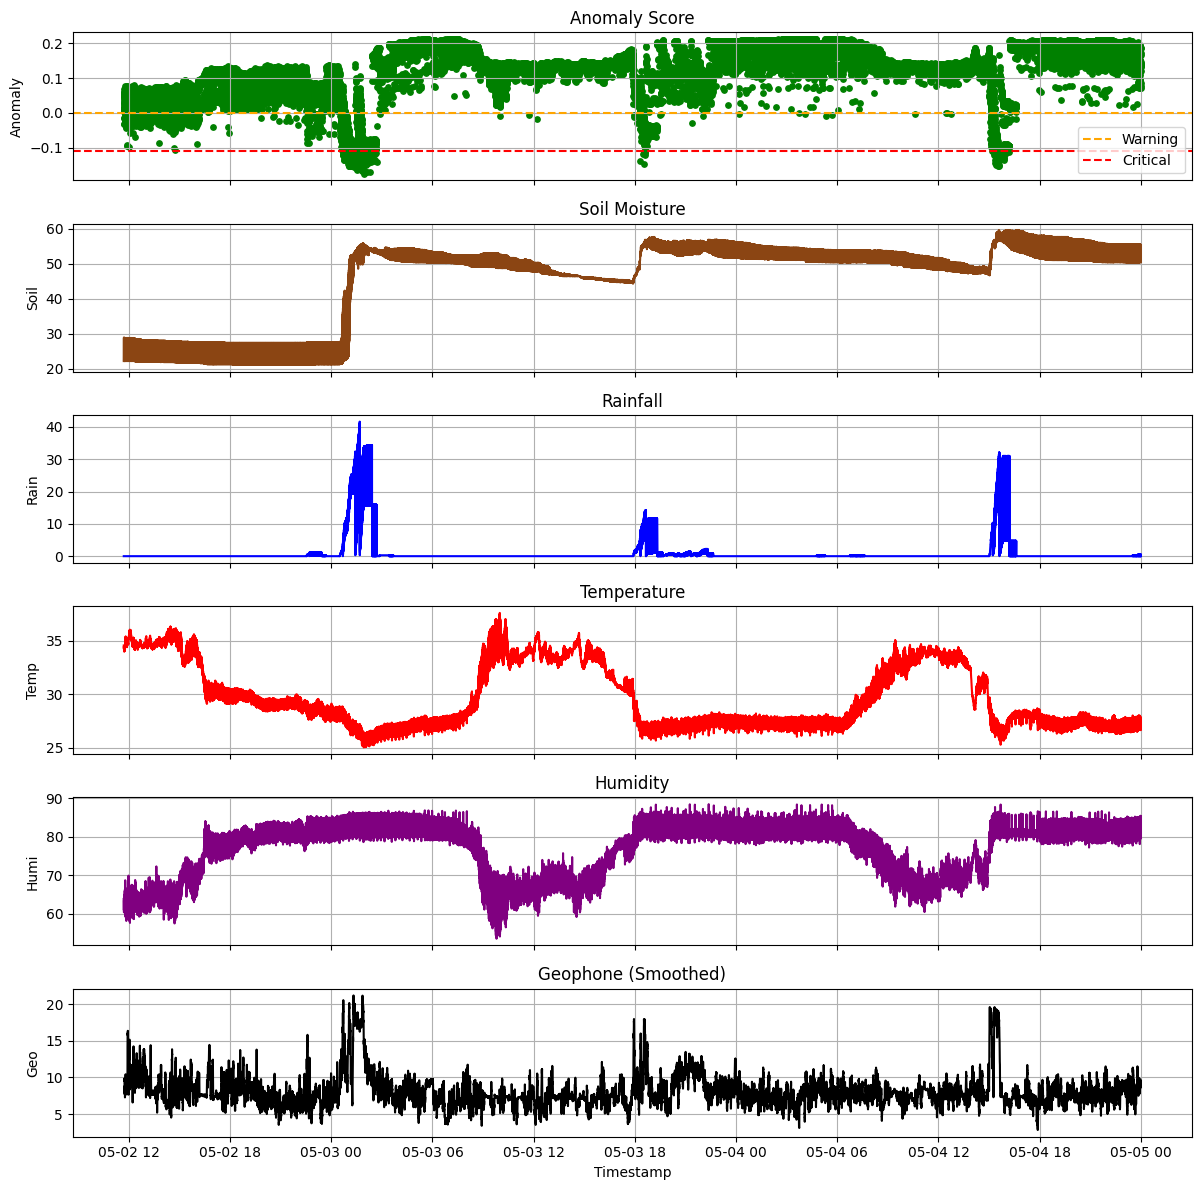

In [17]:
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_dev = df_test.set_index('timestamp').sort_index()
df_range = df_dev.loc["2025-05-02":"2025-05-04"]

# สร้าง subplot 6 แถว
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot 1: Anomaly Score
axs[0].scatter(df_range.index, df_range['anomaly_score'], color='green', s=15)
axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning')
axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical')
axs[0].set_ylabel("Anomaly")
axs[0].set_title("Anomaly Score")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Soil
axs[1].plot(df_range.index, df_range['soil'], color='saddlebrown')
axs[1].set_ylabel("Soil")
axs[1].set_title("Soil Moisture")
axs[1].grid(True)

# Plot 3: Rain
axs[2].plot(df_range.index, df_range['rain'], color='blue')
axs[2].set_ylabel("Rain")
axs[2].set_title("Rainfall")
axs[2].grid(True)

# Plot 4: Temp
axs[3].plot(df_range.index, df_range['temp'], color='red')
axs[3].set_ylabel("Temp")
axs[3].set_title("Temperature")
axs[3].grid(True)

# Plot 5: Humi
axs[4].plot(df_range.index, df_range['humi'], color='purple')
axs[4].set_ylabel("Humi")
axs[4].set_title("Humidity")
axs[4].grid(True)

window_size = 20  # ลองปรับค่าตามความเหมาะสม เช่น 10, 50, 100
smoothed_geo = df_range['geo'].rolling(window=window_size).mean()

axs[5].plot(df_range.index, smoothed_geo, color='black')
axs[5].set_ylabel("Geo")
axs[5].set_title("Geophone (Smoothed)")
axs[5].grid(True)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()


C:\Users\ahmad\AppData\Local\Temp\ipykernel_17756\518179070.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, x='predicted_risk', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


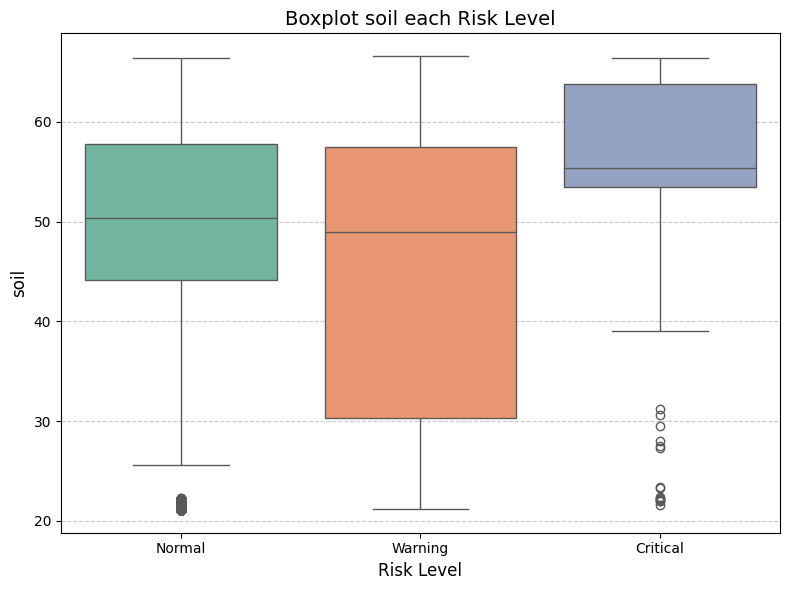

C:\Users\ahmad\AppData\Local\Temp\ipykernel_17756\518179070.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, x='predicted_risk', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


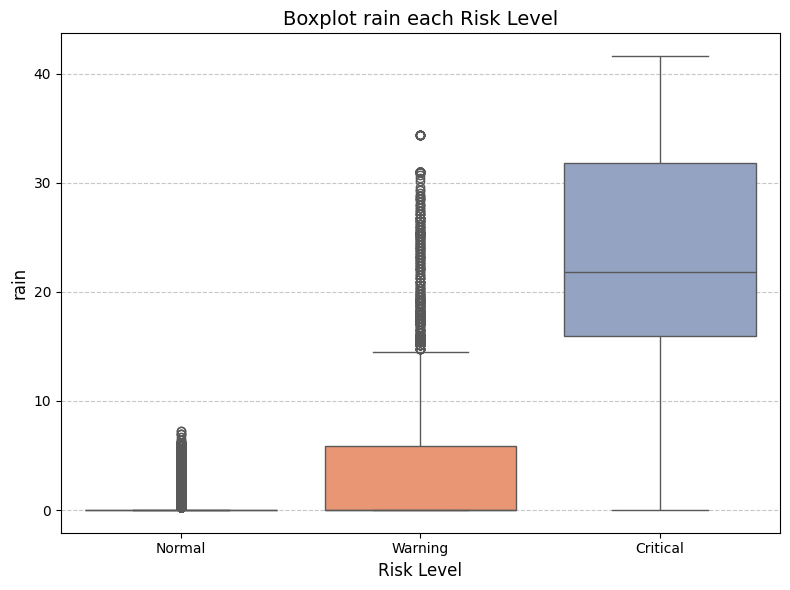

C:\Users\ahmad\AppData\Local\Temp\ipykernel_17756\518179070.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, x='predicted_risk', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


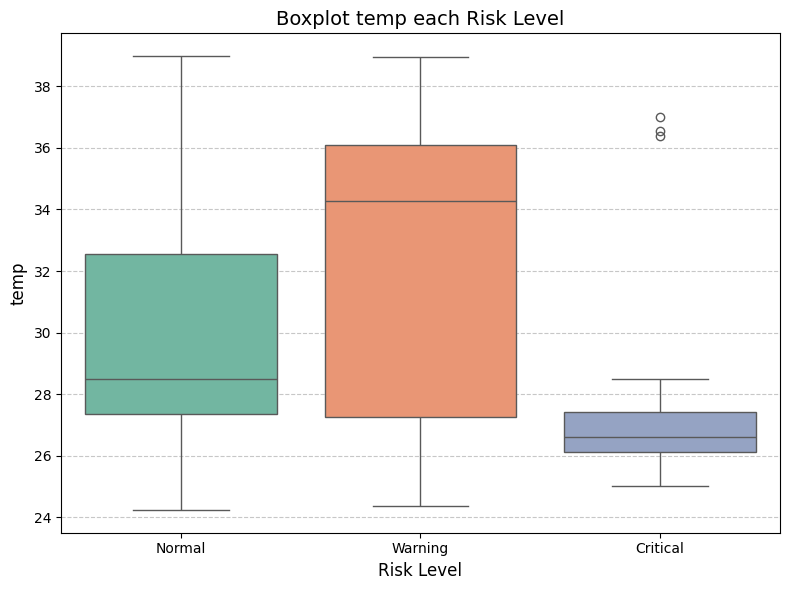

C:\Users\ahmad\AppData\Local\Temp\ipykernel_17756\518179070.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, x='predicted_risk', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


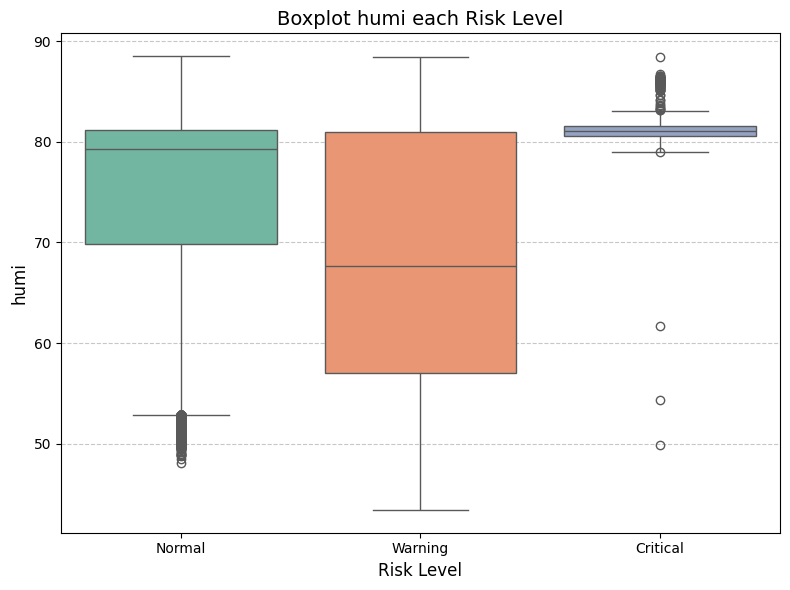

C:\Users\ahmad\AppData\Local\Temp\ipykernel_17756\518179070.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, x='predicted_risk', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


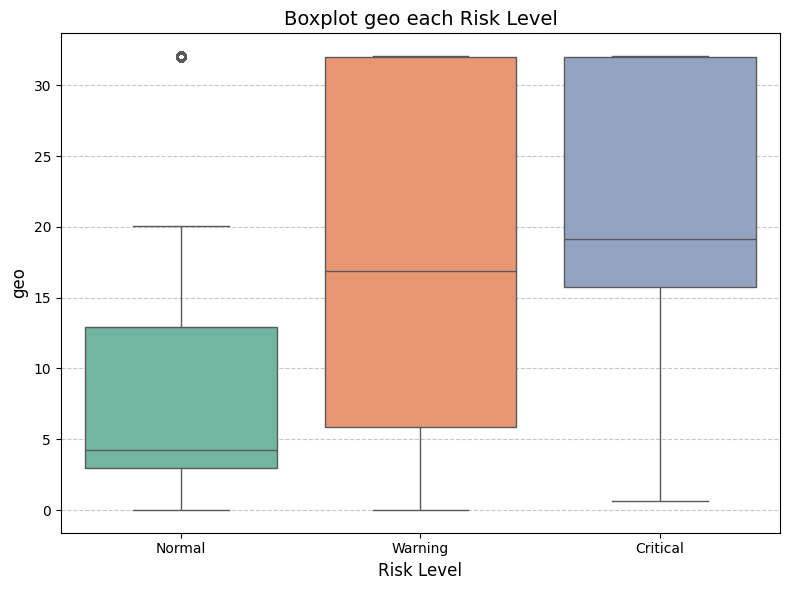

Create Box Plot for every Feature successfully!


In [16]:
for feature in feature_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_test, x='predicted_risk', y=feature, order=['Normal', 'Warning', 'Critical'], palette='Set2')


    plt.title(f'Boxplot {feature} each Risk Level', fontsize=14)
    plt.xlabel('Risk Level', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("Create Box Plot for every Feature successfully!")